In [1]:
import pickle
import collections
import itertools
import lxml.etree as etree
import os
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from random import seed, sample
from datetime import date
import subprocess
import sys
DRIVE_PATH='G:'+os.sep+'Il Mio Drive'+os.sep+'SECRET-ITN'+os.sep+'Projects'+os.sep
DRIVE_PATH='G:'+os.sep+'My Drive'+os.sep+'SECRET-ITN'+os.sep+'Projects'+os.sep
sys.path.append(DRIVE_PATH+'network_signing'+os.sep)

#SECIES = "S_cerevisiae"
#PERT_MAP = 'Holstege'
SPECIES='H_sapiens'
PERT_MAP = 'CMGE'
DATE=str(date.today().strftime("%d/%m/%Y"))
HOME_DIR=DRIVE_PATH+os.sep+'network_signing'+os.sep+'SIGNAL Validations target sign reconstruction'+os.sep+'ANAT_validation_pipeline'+os.sep
MAIN_DATA_DIR = DRIVE_PATH+'Data'+os.sep+SPECIES+os.sep
os.chdir(HOME_DIR)

SIGNAL_OUTPUT_DIR=HOME_DIR+ '2 SIGNAL score networks'+os.sep+'SIGNAL_output'+os.sep
EXPERIMENTAL_INPUT_DIR=HOME_DIR+os.sep+'3 score networks and compare to experiments'+os.sep+'experimental_inputs'+os.sep
OUTPUT_DIR=HOME_DIR+os.sep+'3 score networks and compare to experiments'+os.sep+'output'+os.sep
featurespath=HOME_DIR+'SIGNAL_features'+os.sep

with open( MAIN_DATA_DIR+'alias_2geneid.pkl', 'rb') as f:
    alias_2geneid = pickle.load(f)
geneid2alias ={y:x for (x,y) in alias_2geneid.items()}

network=pd.read_csv(MAIN_DATA_DIR +SPECIES+'.net',sep="\t", header=None)
graph = nx.from_pandas_edgelist(network.reset_index(), 0, 1, 2)

FILENAME = 'TUBB_v_all'#'TLM_all_KOterms_850696'#
    
with open(HOME_DIR+ '2 SIGNAL score networks'+os.sep+FILENAME+'.paths', 'rb') as f:
    paths_to=pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'G:\\My Drive\\SECRET-ITN\\Projects\\\\network_signing\\SIGNAL Validations target sign reconstruction\\ANAT_validation_pipeline\\2 SIGNAL score networks\\TUBB_v_all.paths'

In [6]:
def generate_edges_from_path(path):
    edges=[]
    first=True
    i=0
    for j in path:
        if first:
          first=False
        else:
            edges.append((i,j))
        i=j
    return edges
edges_path_to={}
# Iterate over the paths_to dictionary
for final_node, paths in paths_to.items():
    edges_path_to[final_node]=[]
    # Iterate over the paths for each final node
    for path in paths:
        
        edges = generate_edges_from_path(path)
        edges_path_to[final_node].append(edges)

# Score reconstructed pathways
(see previous steps)
Prints the final predicted SIGNAL of given pathway

In [81]:
#%% Score pathway
t=0.5 #set threshold for negative edge
# attenzione xke questo mi da' un valore 1/0 e alloranon posso crossvalidare mi sa
def score_negative_paths(path,t):
        neg_nodes_p= np.where(path>=t, 1, 0) 
        if sum(neg_nodes_p)%2==1:
            return 1
        else:
            return 0

path_score_of = {}
for final_node, path in edges_path_to.items():
    data=pd.read_csv(SIGNAL_OUTPUT_DIR+final_node+'.edges_'+PERT_MAP+'.ft.pkl.sgnl',sep=' ', header=None, index_col=([0,1]))
    print('gene:',final_node)
    path_score=score_negative_paths(data.values.flatten(), t)
    path_score_of[final_node]=(path_score)
    print('pathway score:', path_score)
    

gene: 4088
pathway score: 0
gene: 3725
pathway score: 0
gene: 7157
pathway score: 0
gene: 6198
pathway score: 0
gene: 1956
pathway score: 0
gene: 4082
pathway score: 0
gene: 84335
pathway score: 0
gene: 5781
pathway score: 0
gene: 4792
pathway score: 0
gene: 2931
pathway score: 0
gene: 207
pathway score: 0
gene: 3315
pathway score: 0
gene: 3014
pathway score: 0
gene: 5600
pathway score: 0
gene: 5604
pathway score: 0
gene: 6774
pathway score: 0
gene: 5595
pathway score: 0
gene: 6195
pathway score: 0
gene: 1385
pathway score: 0
gene: 5747
pathway score: 0


# Original Data
Data is divided into Paclitaxel sensitive (PS) and resistant (PR), at 34h or 40h after treatment.

In [156]:
data=pd.read_csv(EXPERIMENTAL_INPUT_DIR+'multiplex34hPS.txt', sep='\t', index_col=0)
data.columns=[alias_2geneid[col] for col in data.columns]
data

,4088,3725,7157,6198,1956,4082,84335,5781,4792,2931,207,3315,3014,5600,5604,6774,5595,6195,1385,5747
Sample,,,,,,,,,,,,,,,,,,,,
PS 1 - untreated,9016,419.0,41946.0,444.0,1008.5,20016,52588.5,7273,1078.5,8288.5,18563.0,537,205.0,1085.0,4367.5,904.0,799.0,1673.0,25031.5,167
PS 2 - untreated,9117,256.5,41542.5,296.5,1068.0,24029,49728.5,5047,734.0,7335.0,19381.5,498,194.0,939.5,1886.5,1005.5,373.0,1926.5,20431.0,171
PS 3 - untreated,9841,228.5,39732.0,322.0,978.0,23729,48334.0,5304,519.5,6403.0,19301.0,498,185.5,885.0,1703.0,1067.5,440.0,1591.0,18402.0,168
PS 1 - paclitaxel,7517,398.0,42776.0,373.0,1133.5,20408,50524.0,7697,1158.5,7942.0,16736.0,577,212.0,978.5,3958.5,1025.0,779.5,1661.5,24997.0,200
PS 2 - paclitaxel,7150,245.0,40032.0,335.0,1035.0,17399,47665.0,6206,1004.5,6235.0,16983.5,476,225.5,805.0,1595.0,1044.0,345.0,1398.0,18586.0,177
PS 3 - paclitaxel,9666,273.0,41254.0,351.5,1017.0,27349,49118.0,5560,801.5,6151.0,18978.0,511,193.0,935.5,1735.0,1085.5,442.0,1733.0,18287.0,174


<AxesSubplot: >

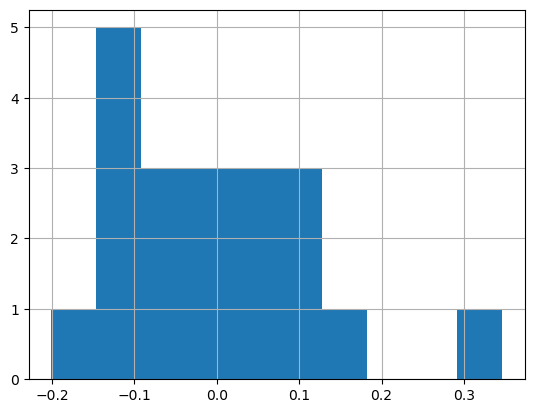

In [157]:
# calculate fold change
pacli = data.tail(3).mean(axis=0)
ctrl =data.head(3).mean(axis=0)
FC=pd.Series(np.log2(pacli.values/ctrl.values), index=pacli.index)
FC.hist()


# Compare to original data through crossvalidation

In [158]:
from sklearn.metrics import roc_curve, auc

def calcROCAUC(Y_true, Y_pred):
    fprs, tprs, thresholds = roc_curve(Y_true, Y_pred)
    aucvalue=auc(fprs, tprs)
    return fprs, tprs, thresholds, aucvalue


In [159]:
FClabels=(FC<0).astype(int)
fprs, tprs, thresholds, aucvalue = calcROCAUC(FClabels, pd.Series(path_score_of))
print(aucvalue)

0.5


Inconclusive stuff, tried with all data 40hPR, 40hPS, 34hPR, 34hPS... all inconclusive. try to make the shortest path method instead of the anat method

Il problema e' che questo e' in human quindi ce ne vuole x fare gli scores...
rifacciamolo con yeast

# 05 10 2023 TLM data rifatto  MA mai piu toccato non mi ricordo manco cosa sia, da cancellare direi

Un file di signal scores non divisi per Anchor - Terminal



In [6]:
import pickle
import collections
import itertools
import lxml.etree as etree
import os
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from random import seed, sample
from datetime import date
import subprocess
import sys
DRIVE_PATH='G:'+os.sep+'Il Mio Drive'+os.sep+'SECRET-ITN'+os.sep+'Projects'+os.sep
DRIVE_PATH='G:'+os.sep+'My Drive'+os.sep+'SECRET-ITN'+os.sep+'Projects'+os.sep
sys.path.append(DRIVE_PATH+'network_signing'+os.sep)
from glob_vars import SPECIES, ANAT_VAL_HOME
FILENAME = 'TLM_all_KOterms.edges_Holstege.sgnl'#'TLM_all_KOterms_850696'#
FILEPATH=ANAT_VAL_HOME+ '2 SIGNAL score networks'+os.sep+'SIGNAL_output'+os.sep+FILENAME
SIGNAL_scores=pd.read_csv(FILEPATH, sep=' ', header=None)
SIGNAL_scores

,0,1,2
0,854198,855203,0.51
1,854198,851259,0.51
2,856351,851485,0.51
3,856351,853064,0.51
4,856351,851263,0.51
...,...,...,...
592,851174,852190,0.51
593,851174,855471,0.51
594,851174,851259,0.51
595,856163,856657,0.51


<Axes: >

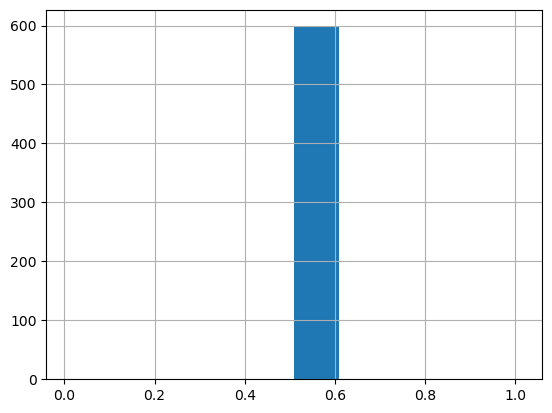

In [4]:
SIGNAL_scores[2].hist()

In [6]:
SIGNAL_scores[2].describe()

count    5.970000e+02
mean     5.100000e-01
std      4.333501e-15
min      5.100000e-01
25%      5.100000e-01
50%      5.100000e-01
75%      5.100000e-01
max      5.100000e-01
Name: 2, dtype: float64